TODO:

- make all the plots for each
- minimum ppi cutoff?
- moving average for scatter plots


Trying to organize the paralog data

Current problems:

- the list of paralog pairs is those tested in Y2H. For M1H and Y1H, we don't need to have tested specific pairs to compare them, so it would be better to use a larger list, I'm not sure exactly how to generate it in a way that is consistent with how the Y2H tested paralog pairs were selected.
- the paralog sequence identity file is old and missing data
- the updated paralog sequence identity file uses different isoform IDs

see here:
https://github.com/CCSB-DFCI/tf_isoforms/issues/12

There are four categories in the Y2H data:

- tf_isoform_ppis      -- isoforms
- tf_paralog_ppis      -- paralogs
- non_paralog_control  -- random other pairs of not paralogs
- paralog_with_PDI     -- **I don't know**



Thoughts:

- How comparable is AA identity between isoforms and between paralogs, since paralogs have evolutionary drift and isoforms don't
- Maybe paralogs can function as redundant backups in a way that isoforms can't
- Maybe paralogs can also totally functionally diverge in a way that isoforms can't

In [3]:
# is gene age same as age of duplication?
# is family size I have OK?
# n_isoforms
# exon divergence (number of exons in ref iso)
# gene expression levels
import numpy as np

from ccsblib.huri import load_gene_age

from data_loading import load_annotated_6k_collection
from data_loading import load_tf_families
# more complete version:
# https://www.sciencedirect.com/science/article/pii/S0093775418302264
# Obtaining estimates for the ages of all the protein-coding genes and most of the ontology-identified noncoding genes of the human genome, assigned to 19 phylostrata
# of cloned genes, 303 have age, 6 do not
tfs = load_annotated_6k_collection()
cloned_tf_ensg = {tf.ensembl_gene_id for tf in tfs.values()}
age = load_gene_age()
age = age.loc[age.index.isin(cloned_tf_ensg)]
age.index = age.index.map({tf.ensembl_gene_id: tf.name for tf in tfs.values()})
fam = load_tf_families()
fam_size = fam.map(fam.value_counts())
fam_size.loc[fam == 'Unknown'] = np.nan

import pyranges
path_gencode_gtf = "../data/external/gencode.v30.annotation.gtf"
algn = pyranges.read_gtf(path_gencode_gtf, duplicate_attr=True)
algn = algn[(algn.Feature == 'gene') &
            algn.gene_id.str.replace(r"\..*", "", regex=True).isin(cloned_tf_ensg)].df
algn = algn.set_index(algn.gene_id.str.replace(r"\..*", "", regex=True))
gene_length = (algn['End'] - algn['Start'])
gene_length.index = gene_length.index.map({tf.ensembl_gene_id: tf.name for tf in tfs.values()})

reading from cache


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/ID_mapping.py:175: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(qry, paros_connection())


In [4]:
# generate a new list of paralogs
# take every pairwise combination of reference isoform?
import itertools

import tqdm
from Bio import Align
import pandas as pd

from data_loading import load_annotated_6k_collection


tfs = load_annotated_6k_collection()
tfs = {k: v for k, v in tfs.items() if len(v.cloned_isoforms) >= 2}

aligner = Align.PairwiseAligner()
aligner.mode = 'global'

def pairwise_global_aa_sequence_similarity(aa_seq_a, aa_seq_b):
    alignment = aligner.align(aa_seq_a, aa_seq_b)[0].__str__().split()[1]
    return alignment.count('|') / len(alignment) * 100

aa_id = []
for tf_a, tf_b in tqdm.tqdm(list(itertools.combinations(tfs.values(), 2))):
    if 'HSFY1' in (tf_a.name, tf_b.name):
        continue  # HACK due to missing gencode isoforms
    aa_id.append((tf_a.name, 
                  tf_b.name,
                  '|'.join(tf_a.reference_isoform.ensembl_transcript_names),
                  '|'.join(tf_b.reference_isoform.ensembl_transcript_names),
                  pairwise_global_aa_sequence_similarity(tf_a.reference_isoform.aa_seq, tf_b.reference_isoform.aa_seq))
    )
aa_id = pd.DataFrame(aa_id, columns=['gene_a', 'gene_b', 'isoform_a', 'isoform_b', 'pct_aa_seq_id'])
aa_id.head()

reading from cache


100%|██████████| 30135/30135 [00:55<00:00, 543.89it/s]


,gene_a,gene_b,isoform_a,isoform_b,pct_aa_seq_id
0,ZBTB18,PRRX1,ZBTB18-201,PRRX1-201,20.123839
1,ZBTB18,POU2F1,ZBTB18-201,POU2F1-204,20.092593
2,ZBTB18,ATF3,ZBTB18-201,ATF3-202|ATF3-206,17.880795
3,ZBTB18,GRHL3,ZBTB18-201,GRHL3-204,22.619048
4,ZBTB18,ZNF691,ZBTB18-201,ZNF691-201|ZNF691-209,21.726619


In [5]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import *
from isoform_pairwise_metrics import pairs_of_paralogs_and_isoforms_comparison_table
from plotting import y2h_ppi_per_paralog_pair_plot

pd.set_option('display.max_columns', 50)

y2h = load_isoform_and_paralog_y2h_data()
y2h = y2h.loc[y2h['category'].isin(['tf_isoform_ppis',
                                    'tf_paralog_ppis',
                                    'non_paralog_control',
                                    'paralog_with_PDI']),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()  # note these are pairs tested in Y2H

# HACK to include other paralog pairs, not tested in Y2H
pairs = pd.concat([pairs,
           aa_id.loc[aa_id['pct_aa_seq_id'] >= 25,
           ['gene_a', 'gene_b', 'pct_aa_seq_id']]
           .rename(columns={'gene_a': 'tf_gene_a',
                   'gene_b': 'tf_gene_b',
                   'pct_aa_seq_id': 'pct_aa_seq_identity'})
            .assign(is_paralog_pair=True)
            ],
         axis=0
        ).drop_duplicates(subset=['tf_gene_a', 'tf_gene_b'])

df = pairs_of_paralogs_and_isoforms_comparison_table(isoforms,
                                                    pairs,
                                                    y2h,
                                                    y1h,
                                                    m1h)
ref_isos = {tf.cloned_reference_isoform.clone_acc for tf in tfs.values()}
df['is_reference_comparison'] = ((df['clone_acc_a'].isin(ref_isos) & 
                                  df['clone_acc_b'].isin(ref_isos) &
                                  df['category'].isin(['paralogs', 'non-paralog-control'])) |
                                  ((df['clone_acc_a'].isin(ref_isos) | 
                                    df['clone_acc_b'].isin(ref_isos)) &
                                   df['category'].isin(['isoforms'])))

In [6]:
# TODO: check that this HACK hasn't messed up the Y2H pairwise
# metrics by including pairs that shouldn't be
df.head()

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|1/3|11C01,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.142965,4.407654,2.264689,2.264689,30.448384,False
ZNF18|1/3|07G04_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|3/3|05A08,paralogs,3.0,0.0,0.0,0.0,0.000000,NaN,3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.142965,-1.793073,1.793073,21.221374,False
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982778,4.407654,1.424876,1.424876,30.508475,True
ZNF18|2/3|07H02_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.982778,-2.632887,2.632887,21.664050,False
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846694,4.407654,1.560961,1.560961,30.540827,False


In [7]:
def family_of_pair(row):
    if fam[row['tf_gene_a']] == fam[row['tf_gene_b']]:
        return fam[row['tf_gene_a']]
    else:
        return np.nan


df['family'] = df.apply(family_of_pair, axis=1)
df['family_size'] = df['family'].map(fam.value_counts())
df.loc[df['family'] == 'Unknown', 'family_size'] = np.nan
df['gene_length_a'] = df['tf_gene_a'].map(gene_length)
df['gene_length_b'] = df['tf_gene_b'].map(gene_length)
df['gene_age_a'] = df['tf_gene_a'].map(age)
df['gene_age_b'] = df['tf_gene_b'].map(age)
df['gene_age_younger'] =(df.loc[:, ['gene_age_a', 'gene_age_b']]
                            .apply(lambda x: np.nan if pd.isnull(x[0]) or pd.isnull(x[1])
                                             else x[0] if x[0] < x[1]
                                             else x[1], axis=1))
df['n_isoforms_a'] = df['tf_gene_a'].map({tf.name: len(tf.orfs) for tf in tfs.values()})
df['n_isoforms_b'] = df['tf_gene_b'].map({tf.name: len(tf.orfs) for tf in tfs.values()})
df['n_exons_a']  = df['clone_acc_a'].map({iso.clone_acc: len(iso.exons) for tf in tfs.values() for iso in tf.cloned_isoforms})
df['n_exons_b']  = df['clone_acc_b'].map({iso.clone_acc: len(iso.exons) for tf in tfs.values() for iso in tf.cloned_isoforms})
df['is_n_exons_equal'] = (df['n_exons_a'] == df['n_exons_b'])

In [10]:
df.loc[df['gene_age_a'] != df['gene_age_b']]

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison,family,family_size,gene_length_a,gene_length_b,gene_age_a,gene_age_b,n_isoforms_a,n_isoforms_b,n_exons_a,n_exons_b,is_n_exons_equal,gene_age_younger
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF24|1/2|01B07_ZNF397|1/5|08C08,ZNF24,ZNF397,ZNF24|1/2|01B07,ZNF397|1/5|08C08,paralogs,3.0,2.0,2.0,0.0,0.666667,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.806491,0.641802,-1.448293,1.448293,34.061135,False,C2H2 ZF,747.0,13256.0,26104.0,Opisthokonta,Eumetazoa,2.0,6.0,3.0,3.0,True,Eumetazoa
ZNF24|1/2|01B07_ZNF397|2/5|11C06,ZNF24,ZNF397,ZNF24|1/2|01B07,ZNF397|2/5|11C06,paralogs,2.0,1.0,1.0,0.0,0.500000,1.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.464479,0.641802,-1.106282,1.106282,31.492843,True,C2H2 ZF,747.0,13256.0,26104.0,Opisthokonta,Eumetazoa,2.0,6.0,3.0,5.0,False,Eumetazoa
ZNF24|1/2|01B07_ZNF397|3/5|08H07,ZNF24,ZNF397,ZNF24|1/2|01B07,ZNF397|3/5|08H07,paralogs,3.0,1.0,2.0,1.0,0.333333,0.5,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.537981,0.641802,-1.179783,1.179783,30.148620,False,C2H2 ZF,747.0,13256.0,26104.0,Opisthokonta,Eumetazoa,2.0,6.0,3.0,4.0,False,Eumetazoa
ZNF24|1/2|01B07_ZNF397|4/5|08G07,ZNF24,ZNF397,ZNF24|1/2|01B07,ZNF397|4/5|08G07,paralogs,3.0,1.0,2.0,1.0,0.333333,0.5,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.028244,0.641802,-1.670047,1.670047,29.213483,False,C2H2 ZF,747.0,13256.0,26104.0,Opisthokonta,Eumetazoa,2.0,6.0,3.0,2.0,False,Eumetazoa
ZNF24|1/2|01B07_ZNF397|5/5|08B08,ZNF24,ZNF397,ZNF24|1/2|01B07,ZNF397|5/5|08B08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.199794,0.641802,-0.841596,0.841596,28.110599,False,C2H2 ZF,747.0,13256.0,26104.0,Opisthokonta,Eumetazoa,2.0,6.0,3.0,3.0,True,Eumetazoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOX5|2/2|08B02_SOX6|7/7|07C07,SOX6,SOX5,SOX6|7/7|07C07,SOX5|2/2|08B02,paralogs,20.0,0.0,0.0,0.0,0.000000,NaN,20.0,-20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382021,1.038682,0.656661,0.656661,30.857143,False,HMG/Sox,30.0,773143.0,1033045.0,Eumetazoa,NaN,9.0,8.0,14.0,7.0,False,NaN
AEBP2|2/3|05F03_AEBP2|3/3|05E07,AEBP2,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,isoforms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.234322,0.301297,-0.535619,0.535619,82.000000,True,C2H2 ZF,747.0,316757.0,316757.0,NaN,NaN,6.0,6.0,7.0,8.0,False,NaN
PCGF6|1/2|11A10_PCGF6|2/2|11B07,PCGF6,PCGF6,PCGF6|1/2|11A10,PCGF6|2/2|11B07,isoforms,1.0,0.0,0.0,0.0,0.000000,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.507135,2.813582,-4.320717,4.320717,78.400000,False,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


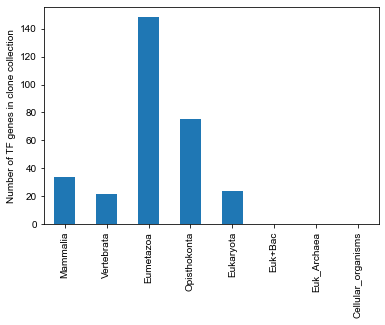

In [90]:
fig, ax = plt.subplots(1, 1)
age.value_counts().sort_index().plot.bar(ax=ax)
ax.set_ylabel('Number of TF genes in clone collection')
fig.savefig('../figures/gene-age_TFiso_bar.pdf', bbox_inches='tight')

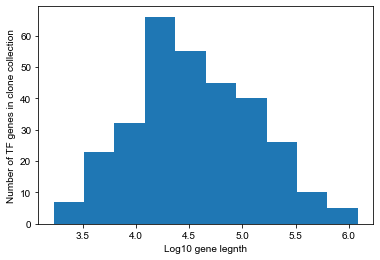

In [99]:
fig, ax = plt.subplots(1, 1)
gene_length.apply(np.log10).plot.hist(ax=ax)
ax.set_ylabel('Number of TF genes in clone collection')
ax.set_xlabel('Log10 gene legnth')
fig.savefig('../figures/gene-length_log10_TFiso_hist.pdf', bbox_inches='tight')

In [103]:
df['category'].value_counts()

paralogs               1018
isoforms                804
non-paralog-control     140
Name: category, dtype: int64

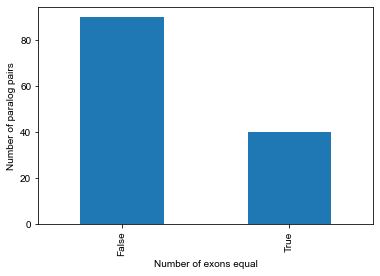

In [106]:
fig, ax = plt.subplots(1, 1)
df.loc[df['is_reference_comparison'] & (df['category'] == 'paralogs'), 'is_n_exons_equal'].value_counts().plot.bar(ax=ax)
ax.set_xlabel('Number of exons equal')
ax.set_ylabel('Number of paralog pairs')
fig.savefig('../figures/n-exons-equal_paralog-pairs_bar.pdf', bbox_inches='tight')

In [ ]:
# split ppi etc by exon divergence

In [39]:
(pairs.loc[pairs['is_paralog_pair'], 'pct_aa_seq_identity'] >= 20).sum()

1782

In [40]:
(aa_id['pct_aa_seq_id'] > 20).sum()

22299

In [51]:
# TMP - copy back to .py file
from plotting import binary_profile_matrix, strikethrough, isoform_display_name
from isoform_pairwise_metrics import paralog_pair_ppi_table

def y2h_ppi_per_paralog_pair_plot(tf_gene_a,
                                  tf_gene_b,
                                  data,
                                  ax=None,
                                  min_n_isoforms=1,
                                  min_n_partners=1):
    """

    TODO: gap between the two genes?
    
    Arguments:
        tf_gene_a {str} -- [description]
        tf_gene_b {str} -- [description]
        data {pandas.DataFrame} -- [description]
        ax {pandas.DataFrame} -- [description] (default: {None})
        min_n_isoforms {int} -- [description] (default: {1})
        min_n_partners {int} -- [description] (default: {1})
    
    """
    tf = paralog_pair_ppi_table(data, tf_gene_a, tf_gene_b)
    #tf['Y2H_result'] = tf['Y2H_result'].map({'1': True,
    #                               '0': False,
    #                               'AA': np.nan,
    #                               'NC': np.nan})
    tf['ad_clone_acc'] = tf['ad_clone_acc'].apply(isoform_display_name)
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PPI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        return
    binary_profile_matrix(tf, ax=ax, column_label_rotation=90)
    ax.set_yticklabels([strikethrough(name) if all_na else name
                        for name, all_na in tf.isnull().all(axis=1).iteritems()])

<ipython-input-51-297e712aa891>:48: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, all_na in tf.isnull().all(axis=1).iteritems()])


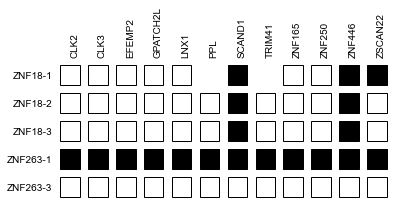

In [52]:
fig, ax = plt.subplots(1, 1)
gene_a = 'ZNF18'
gene_b = 'ZNF263'
y2h_ppi_per_paralog_pair_plot(gene_a, gene_b, y2h, ax=ax)

In [53]:
df.loc[df['tf_gene_a'].isin([gene_a, gene_b]) &
       df['tf_gene_b'].isin([gene_a, gene_b]), :]

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|1/3|11C01,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.142965,4.407654,2.264689,2.264689,30.448384,False
ZNF18|1/3|07G04_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|3/3|05A08,paralogs,3.0,0.0,0.0,0.0,0.000000,NaN,3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.142965,-1.793073,1.793073,21.221374,False
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982778,4.407654,1.424876,1.424876,30.508475,True
ZNF18|2/3|07H02_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.982778,-2.632887,2.632887,21.664050,False
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846694,4.407654,1.560961,1.560961,30.540827,False
ZNF18|3/3|07D01_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.846694,-2.496802,2.496802,21.698113,False
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF263,ZNF18,ZNF263|1/3|11C01,ZNF18|1/3|07G04,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.142965,4.407654,-2.264689,2.264689,30.448384,False
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF263,ZNF18,ZNF263|1/3|11C01,ZNF18|2/3|07H02,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,-10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982778,4.407654,-1.424876,1.424876,30.508475,True
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF263,ZNF18,ZNF263|1/3|11C01,ZNF18|3/3|07D01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,-10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846694,4.407654,-1.560961,1.560961,30.540827,False


<ipython-input-51-297e712aa891>:48: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, all_na in tf.isnull().all(axis=1).iteritems()])


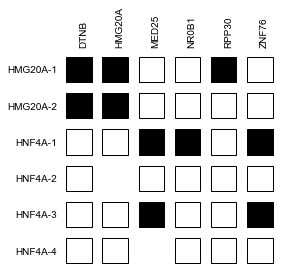

In [54]:
# non-paralog control
fig, ax = plt.subplots(1, 1)
y2h_ppi_per_paralog_pair_plot('HMG20A', 'HNF4A', y2h, ax=ax)

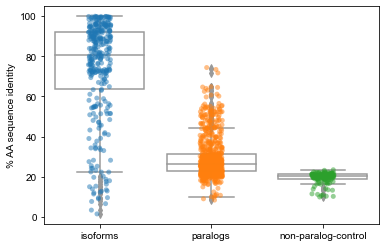

In [27]:
# sequence similarity
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df,
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.boxplot(data=df,
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='white',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('% AA sequence identity')
fig.savefig('../figures/isoforms_vs_paralogs_all_pairs_aa_seq_id.pdf',
            bbox_inches='tight')

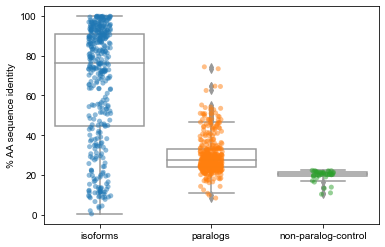

In [3]:
# sequence similarity
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['is_reference_comparison'], :],
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.boxplot(data=df.loc[df['is_reference_comparison'], :],
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='white',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('% AA sequence identity')
fig.savefig('../figures/isoforms_vs_paralogs_aa_seq_id.pdf',
            bbox_inches='tight')

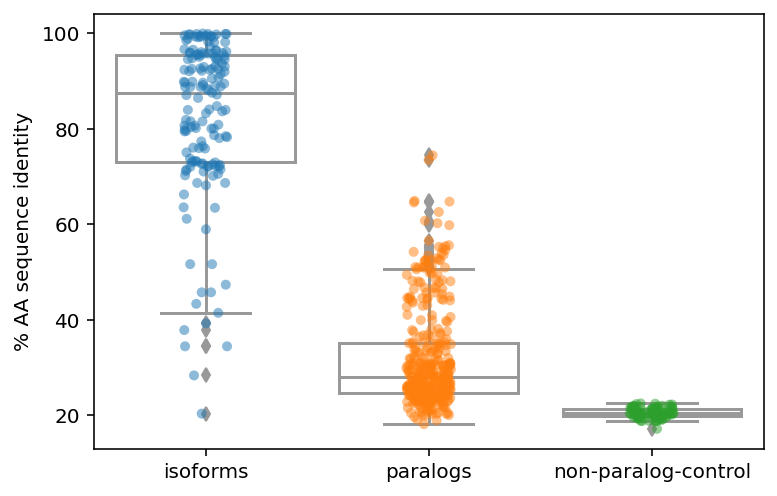

In [9]:
# sequence similarity
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['ppi_n_min'] > 0, :],
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.boxplot(data=df.loc[df['ppi_n_min'] > 0, :],
            x='category',
            y='aa_seq_pct_id',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='white',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('% AA sequence identity')
fig.savefig('../figures/isoforms_vs_paralogs_with_ppi_aa_seq_id.pdf',
            bbox_inches='tight')

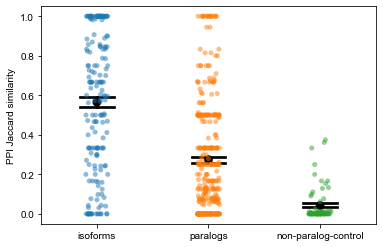

In [4]:
# cat plot with ppi jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['ppi_n_min'] > 0, :],
            x='category',
            y='ppi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df.loc[df['ppi_n_min'] > 0, :],
            x='category',
            y='ppi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_all_pairs_ppi_jaccard.pdf',
            bbox_inches='tight')

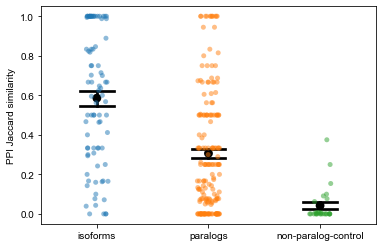

In [5]:
# cat plot with ppi jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['is_reference_comparison'] & (df['ppi_n_min'] > 0), :],
            x='category',
            y='ppi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df.loc[df['is_reference_comparison'] & (df['ppi_n_min'] > 0), :],
            x='category',
            y='ppi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_ppi_jaccard.pdf',
            bbox_inches='tight')

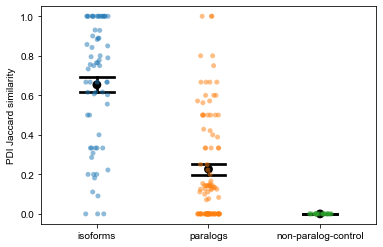

In [6]:
# PDI jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['pdi_n_min'] > 0, :],
            x='category',
            y='pdi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df.loc[df['pdi_n_min'] > 0, :],
            x='category',
            y='pdi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_all_pairs_pdi_jaccard.pdf',
            bbox_inches='tight')

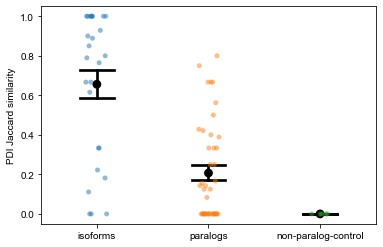

In [7]:
# PDI jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['is_reference_comparison'] & (df['pdi_n_min'] > 0), :],
            x='category',
            y='pdi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df.loc[df['is_reference_comparison'] & (df['pdi_n_min'] > 0), :],
            x='category',
            y='pdi_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_pdi_jaccard.pdf',
            bbox_inches='tight')

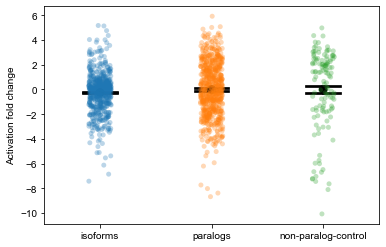

In [8]:
# activation change
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[:, :],
            x='category',
            y='activation_abs_fold_change',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.3,
            ax=ax)
sns.pointplot(data=df.loc[:, :],
            x='category',
            y='activation_abs_fold_change',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Activation fold change')
fig.savefig('../figures/isoforms_vs_paralogs_all_pairs_activation.pdf',
            bbox_inches='tight')

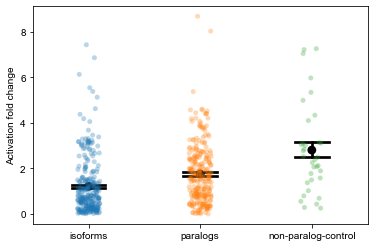

In [5]:
# activation change
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['is_reference_comparison'], :],
            x='category',
            y='activation_abs_fold_change',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.3,
            ax=ax)
sns.pointplot(data=df.loc[df['is_reference_comparison'], :],
            x='category',
            y='activation_abs_fold_change',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Activation fold change')
fig.savefig('../figures/isoforms_vs_paralogs_activation.pdf',
            bbox_inches='tight')

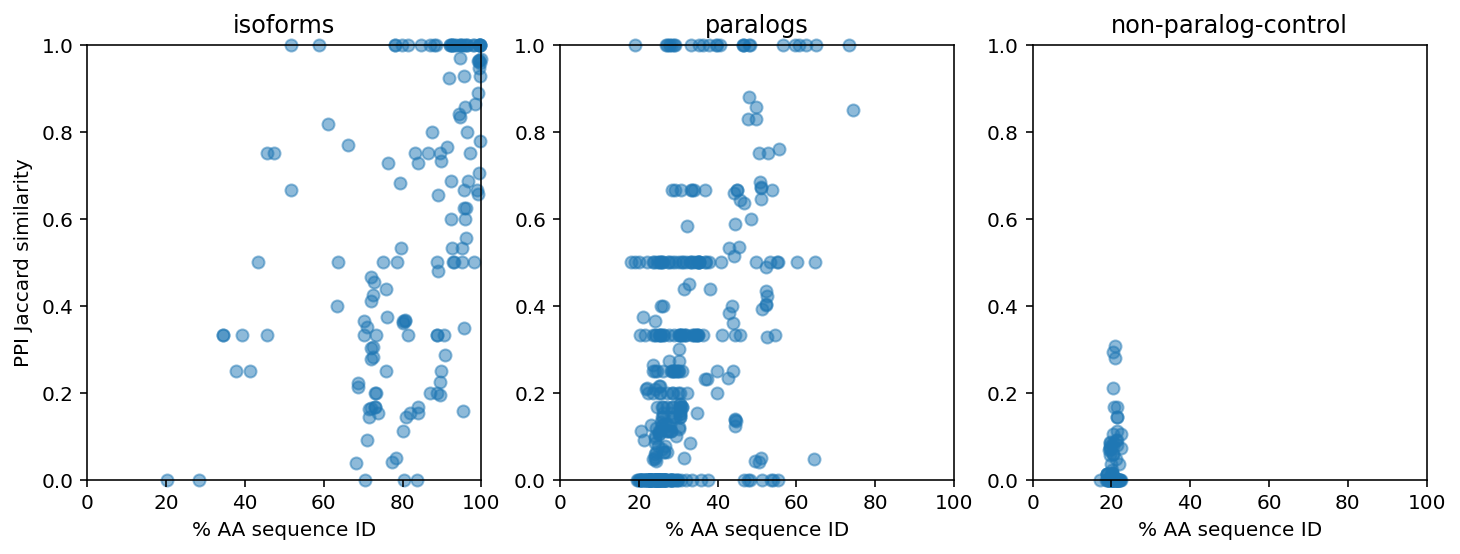

In [13]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat) &
           (df['ppi_n_min'] > 0),
            ['aa_seq_pct_id', 'ppi_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
axes[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_ppi_jaccard_panels.pdf',
            bbox_inches='tight')

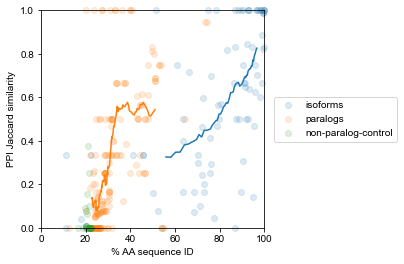

In [9]:
# add moving average
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
window_size = 30
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[df['is_reference_comparison'] &
            (df['category'] == cat) &
           (df['ppi_n_min'] > 0),
            ['aa_seq_pct_id', 'ppi_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat)
    avrg = (df.loc[df['is_reference_comparison'] & (df['category'] == cat) &
           (df['ppi_n_min'] > 0),
            :]
         .sort_values('aa_seq_pct_id')
         .rolling(window_size, center=True)
         .mean()[['aa_seq_pct_id', 'ppi_jaccard']]).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1])
     
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PPI Jaccard similarity')
ax.legend(loc='center left', bbox_to_anchor=[1.02, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_ppi_jaccard_onefig.pdf',
            bbox_inches='tight')

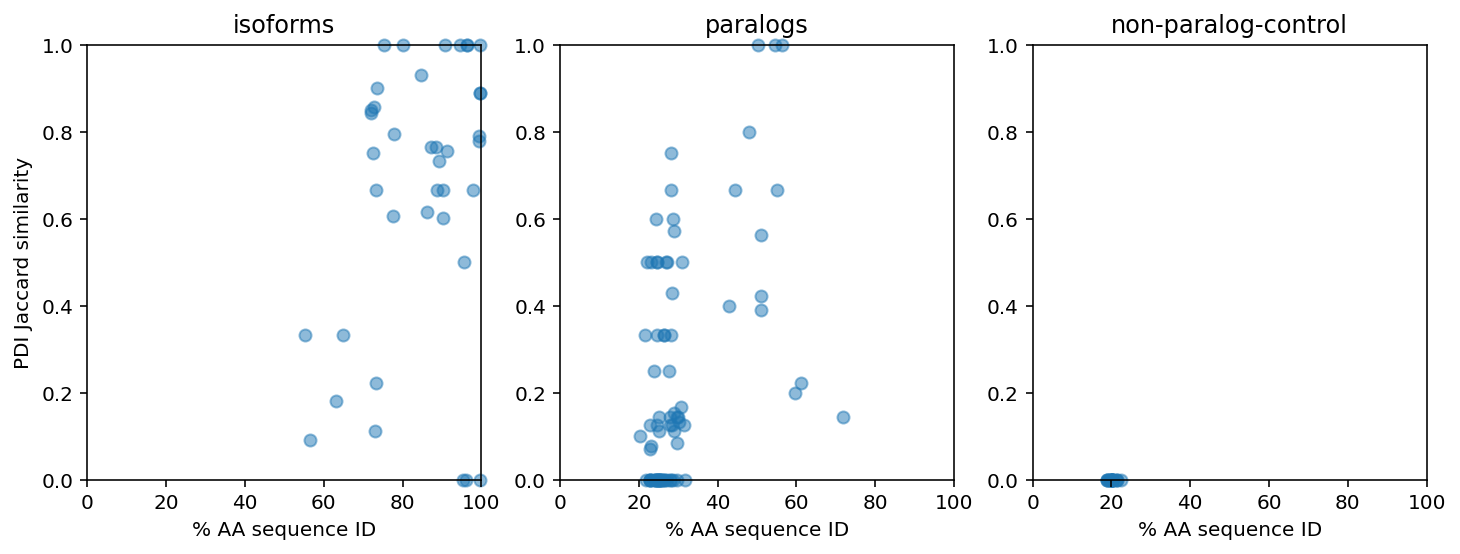

In [15]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat) &
           (df['pdi_n_min'] > 0),
            ['aa_seq_pct_id', 'pdi_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
axes[0].set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_pdi_jaccard_panels.pdf',
            bbox_inches='tight')

In [20]:
df.head()

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison
pair,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|1/3|11C01,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.264689,2.264689,30.448384,False
ZNF18|1/3|07G04_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|3/3|05A08,paralogs,3.0,0.0,0.0,0.0,0.000000,NaN,3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.793073,1.793073,21.221374,False
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.424876,1.424876,30.508475,True
ZNF18|2/3|07H02_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.632887,2.632887,21.664050,True
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.560961,1.560961,30.540827,False


In [21]:
df.loc[df['is_reference_comparison'] & (df['category'] == 'isoforms') &
           (df['pdi_jaccard'].notnull())].shape

(56, 25)

In [15]:
y1h.head()

,tf,unique_acc,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,HS1185,HS1199,HS1208,HS1242,HS1271,HS129,HS1315,HS1329,HS1339,HS135,HS1419,HS1436,HS1480,HS149,HS151,HS1516,...,MUT_156,MUT_158,MUT_162,MUT_163,MUT_166,MUT_17,MUT_187,MUT_19,MUT_193,MUT_20,MUT_207,MUT_214,MUT_218,MUT_219,MUT_260,MUT_281,MUT_30,MUT_32,MUT_36,MUT_37,MUT_40,MUT_41,MUT_46,MUT_64,MUT_75
162,CREB1,CREB1|1/2|02E01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0,CREB1,CREB1|2/2|01F12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,DLX1,DLX1|1/2|07A12,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
174,DLX1,DLX1|2/2|07E09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,DLX4,DLX4|1/3|11A04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
# 158 isoforms with Y1H data
# 55 genes with at least two isoforms
(y1h.groupby('tf').size() >= 2).sum()

55

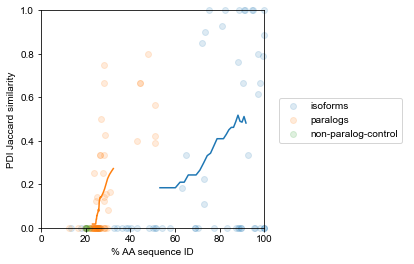

In [22]:
window_size = 30

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)

for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[df['is_reference_comparison'] & (df['category'] == cat) &
           (df['pdi_jaccard'].notnull()),
            ['aa_seq_pct_id', 'pdi_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat)
    avrg = (df.loc[df['is_reference_comparison'] & (df['category'] == cat) &
           (df['pdi_jaccard'].notnull()),
            :]
         .sort_values('aa_seq_pct_id')
         .rolling(window_size, center=True)
         .mean()[['aa_seq_pct_id', 'pdi_jaccard']]).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PDI Jaccard similarity')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_pdi_jaccard_onefig.pdf',
            bbox_inches='tight')

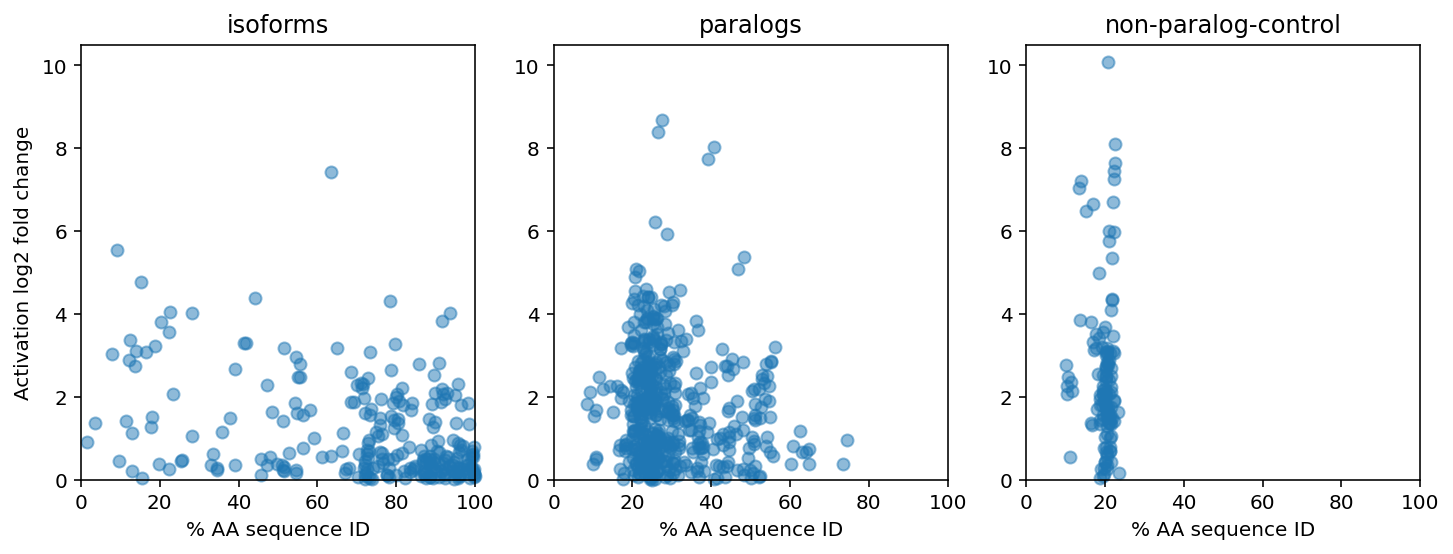

In [17]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat) &
           (df['activation_fold_change'].notnull()),
            ['aa_seq_pct_id', 'activation_fold_change']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 10.5)
    ax.set_title(cat)
axes[0].set_ylabel('Activation log2 fold change')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_panels.pdf',
            bbox_inches='tight')

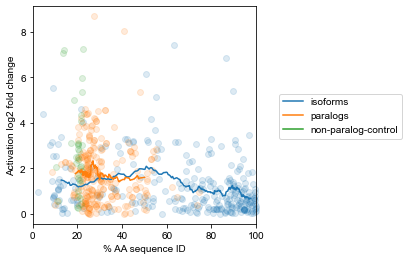

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
window_size = 40
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[df['is_reference_comparison'] & (df['category'] == cat) &
           (df['activation_fold_change'].notnull()),
            ['aa_seq_pct_id', 'activation_abs_fold_change']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               )
    avrg = (df.loc[df['is_reference_comparison'] & (df['category'] == cat) &
           (df['activation_abs_fold_change'].notnull()),
            :]
         .sort_values('aa_seq_pct_id')
         .rolling(window_size, center=True)
         .mean()[['aa_seq_pct_id', 'activation_abs_fold_change']]).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1],
            label=cat)
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
#ax.set_ylim(0, 10.5)
ax.set_ylabel('Activation log2 fold change')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_onefig.pdf',
            bbox_inches='tight')

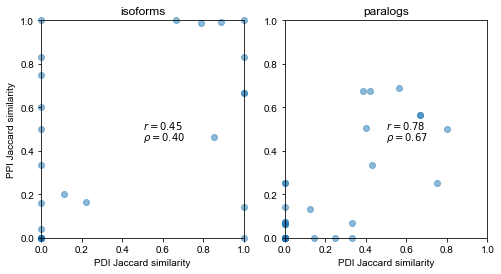

In [6]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xy = df.loc[(df['category'] == cat) &
                df['is_reference_comparison'] &
                ((df['ppi_n_min'] > 0) |
                 (df['pdi_n_min'].notnull())) &
                 df['ppi_jaccard'].notnull() &
                 df['pdi_jaccard'].notnull(),
            ['pdi_jaccard', 'ppi_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('PDI Jaccard similarity')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
    ax.text(0.5, 0.5, r'$r = {:.2f}$'.format(stats.pearsonr(xy[:, 0], xy[:, 1])[0]))
    ax.text(0.5, 0.45, r'$\rho = {:.2f}$'.format(stats.spearmanr(xy[:, 0], xy[:, 1])[0]))
axes[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_pdi_vs_ppi_jaccard_panels.pdf',
            bbox_inches='tight')

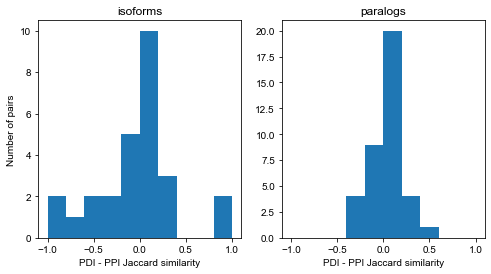

In [51]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xy = df.loc[(df['category'] == cat) &
                df['is_reference_comparison'] &
                ((df['ppi_n_min'] > 0) |
                 (df['pdi_n_min'].notnull())) &
                 df['ppi_jaccard'].notnull() &
                 df['pdi_jaccard'].notnull(),
            ['pdi_jaccard', 'ppi_jaccard']].values
    ax.hist(xy[:, 0] - xy[:, 1], bins=10, range=(-1, 1))
    ax.set_title(cat)
    ax.set_xlabel('PDI - PPI Jaccard similarity')
axes[0].set_ylabel('Number of pairs')
fig.savefig('../figures/isoforms_vs_paralogs_pdi_minus_ppi_jaccard_hist.pdf',
            bbox_inches='tight')

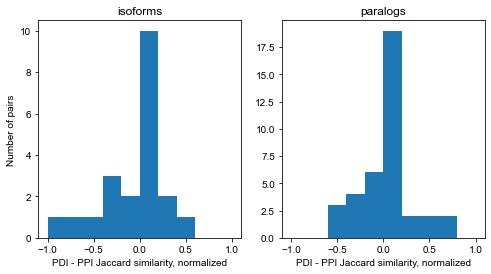

In [52]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xy = df.loc[(df['category'] == cat) &
                df['is_reference_comparison'] &
                ((df['ppi_n_min'] > 0) |
                 (df['pdi_n_min'].notnull())) &
                 df['ppi_jaccard'].notnull() &
                 df['pdi_jaccard'].notnull(),
            ['pdi_jaccard', 'ppi_jaccard']].values
    ax.hist((xy[:, 0] - xy[:, 1]) / ((xy.sum(axis=1) + 1) / 3), bins=10, range=(-1, 1))
    ax.set_title(cat)
    ax.set_xlabel('PDI - PPI Jaccard similarity, normalized')
axes[0].set_ylabel('Number of pairs')
fig.savefig('../figures/isoforms_vs_paralogs_pdi_minus_ppi_jaccard_normalized_hist.pdf',
            bbox_inches='tight')

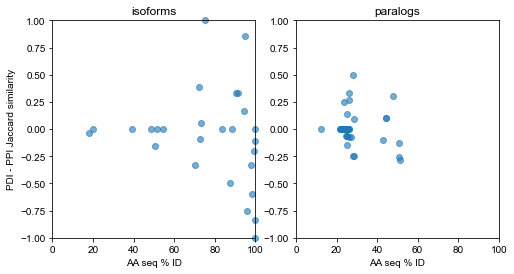

In [53]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xyz = df.loc[(df['category'] == cat) &
                df['is_reference_comparison'] &
                ((df['ppi_n_min'] > 0) |
                 (df['pdi_n_min'].notnull())) &
                 df['ppi_jaccard'].notnull() &
                 df['pdi_jaccard'].notnull(),
            ['pdi_jaccard', 'ppi_jaccard', 'aa_seq_pct_id']].values
    ax.scatter( xyz[:, 2], xyz[:, 0] - xyz[:, 1], clip_on=False, alpha=0.6)
    ax.set_xlabel('AA seq % ID')
    ax.set_ylim(-1, 1)
    ax.set_xlim(0, 100)
    ax.set_title(cat)
axes[0].set_ylabel('PDI - PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_pdi_minus_ppi_jaccard_vs_aa_seq_id_scatter.pdf',
            bbox_inches='tight')

In [7]:
# add TF family info
from data_loading import load_tf_families

fam = load_tf_families()

In [8]:
fam.head()

HGNC symbol
TFAP2A    AP-2
TFAP2B    AP-2
TFAP2C    AP-2
TFAP2D    AP-2
TFAP2E    AP-2
Name: DBD, dtype: object

In [38]:
df['family'].value_counts().index[:7]

Index(['C2H2 ZF', 'Nuclear receptor', 'bHLH', 'Homeodomain', 'HMG/Sox', 'bZIP',
       'SMAD'],
      dtype='object')

In [34]:
df['family'].value_counts()

C2H2 ZF                    619
Nuclear receptor           344
bHLH                       215
Homeodomain                186
HMG/Sox                     80
bZIP                        59
SMAD                        40
Grainyhead                  36
Ets                         33
Forkhead                    27
E2F                         23
TEA                         19
T-box                       17
STAT                        16
p53                         16
Myb/SANT                    12
Paired box                  11
THAP finger                 11
IRF                          9
Homeodomain; Paired box      7
EBF1                         7
AP-2                         6
RFX                          6
Rel                          4
C2H2 ZF; AT hook             3
CBF/NF-Y                     3
CSL                          3
GATA                         2
HSF                          2
SAND                         1
CCCH ZF                      1
Unknown                      1
AT hook 

In [35]:
fam.value_counts().head(30)

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
AT hook              16
Homeodomain; POU     16
Myb/SANT             14
THAP finger          12
E2F                  11
CENPB                11
Rel                  10
BED ZF               10
GATA                 10
CxxC                  9
SMAD                  9
IRF                   9
SAND                  9
HSF                   8
MBD                   8
RFX                   8
STAT                  7
CUT; Homeodomain      7
DM                    7
Grainyhead            6
Name: DBD, dtype: int64

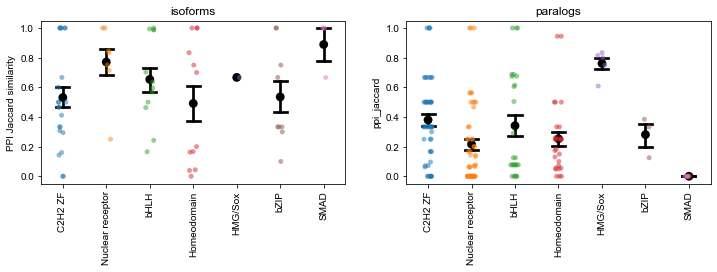

In [40]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[df['is_reference_comparison'] &
                            (df['ppi_n_min'] > 0) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='ppi_jaccard',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[df['is_reference_comparison'] &
                            (df['ppi_n_min'] > 0) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='ppi_jaccard',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_PPI-Jaccard.pdf',
            bbox_inches='tight')

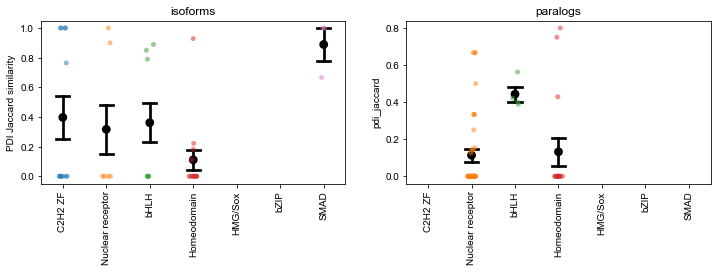

In [41]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[df['is_reference_comparison'] &
                            (df['pdi_jaccard'].notnull()) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='pdi_jaccard',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[df['is_reference_comparison'] &
                            (df['pdi_jaccard'].notnull()) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='pdi_jaccard',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_PDI-Jaccard.pdf',
            bbox_inches='tight')

In [107]:
df.head()

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison,family,family_size,gene_length_a,gene_length_b,gene_age_a,gene_age_b,n_isoforms_a,n_isoforms_b,n_exons_a,n_exons_b,is_n_exons_equal,gene_age_younger
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|1/3|11C01,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.142965,4.407654,2.264689,2.264689,30.448384,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta
ZNF18|1/3|07G04_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|3/3|05A08,paralogs,3.0,0.0,0.0,0.0,0.000000,NaN,3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.142965,-1.793073,1.793073,21.221374,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,2.0,False,Opisthokonta
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982778,4.407654,1.424876,1.424876,30.508475,True,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta
ZNF18|2/3|07H02_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.982778,-2.632887,2.632887,21.664050,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,2.0,False,Opisthokonta
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846694,4.407654,1.560961,1.560961,30.540827,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta


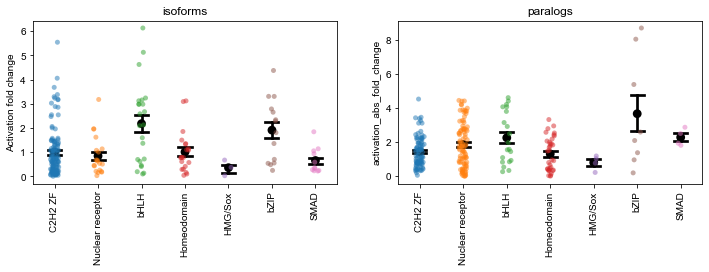

In [43]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[df['is_reference_comparison'] &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='activation_abs_fold_change',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[df['is_reference_comparison'] &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='activation_abs_fold_change',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('Activation fold change')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_activation-abs-foldchange.pdf',
            bbox_inches='tight')

MannwhitneyuResult(statistic=537.5, pvalue=0.04672151253242536)
MannwhitneyuResult(statistic=23.0, pvalue=0.27248749440531594)
MannwhitneyuResult(statistic=662.0, pvalue=0.22040772975208478)


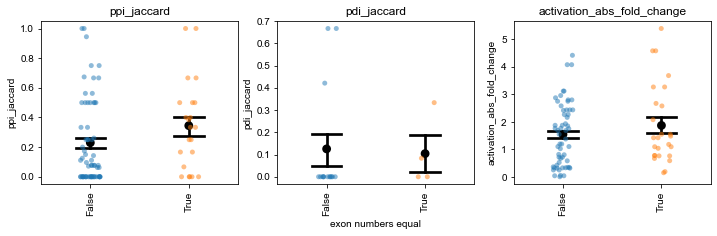

In [11]:
# TODO out of order
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(w=12, h=3)
for var, ax in zip(['ppi_jaccard', 'pdi_jaccard', 'activation_abs_fold_change'], axs):
    data = df.loc[df['is_reference_comparison'] &
                  (df['category'] == 'paralogs'), :]
    sns.stripplot(data=data,
                x='is_n_exons_equal',
                y=var,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=data,
                x='is_n_exons_equal',
                y=var,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    print(stats.mannwhitneyu(data.loc[data['is_n_exons_equal'] & data[var].notnull(), var].values,
        data.loc[~data['is_n_exons_equal'] & data[var].notnull(), var].values))
    ax.set_title(var)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
#axs[0].set_ylabel('Activation fold change')
axs[1].set_xlabel('exon numbers equal')
fig.savefig('../figures/paralogs_by-exon-n-equal_assaydiffs.pdf',
            bbox_inches='tight')

In [12]:
df.head()

,tf_gene_a,tf_gene_b,clone_acc_a,clone_acc_b,category,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison,family,family_size,gene_length_a,gene_length_b,gene_age_a,gene_age_b,n_isoforms_a,n_isoforms_b,n_exons_a,n_exons_b,is_n_exons_equal,gene_age_younger
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZNF18|1/3|07G04_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|1/3|11C01,paralogs,10.0,3.0,3.0,0.0,0.300000,1.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.142965,4.407654,2.264689,2.264689,30.448384,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta
ZNF18|1/3|07G04_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|1/3|07G04,ZNF263|3/3|05A08,paralogs,3.0,0.0,0.0,0.0,0.000000,NaN,3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.142965,-1.793073,1.793073,21.221374,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,2.0,False,Opisthokonta
ZNF18|2/3|07H02_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982778,4.407654,1.424876,1.424876,30.508475,True,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta
ZNF18|2/3|07H02_ZNF263|3/3|05A08,ZNF18,ZNF263,ZNF18|2/3|07H02,ZNF263|3/3|05A08,paralogs,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349892,2.982778,-2.632887,2.632887,21.664050,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,2.0,False,Opisthokonta
ZNF18|3/3|07D01_ZNF263|1/3|11C01,ZNF18,ZNF263,ZNF18|3/3|07D01,ZNF263|1/3|11C01,paralogs,12.0,2.0,2.0,0.0,0.166667,1.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846694,4.407654,1.560961,1.560961,30.540827,False,C2H2 ZF,747.0,20037.0,37602.0,Opisthokonta,Opisthokonta,3.0,4.0,6.0,6.0,True,Opisthokonta


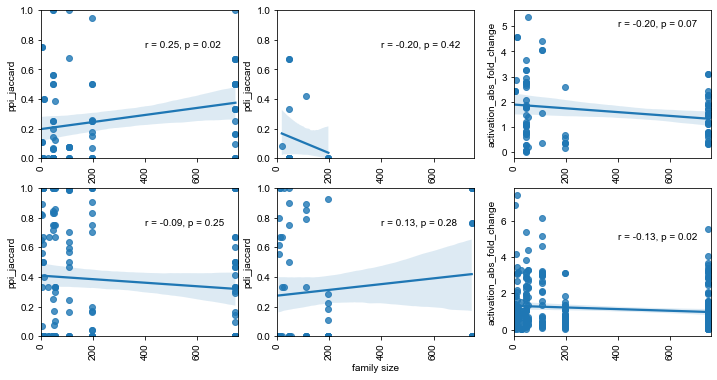

In [95]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['ppi_jaccard', 'pdi_jaccard', 'activation_abs_fold_change'], ax_row):
        data = df.loc[df['is_reference_comparison'] &
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='family_size',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        ax.set_xlim(0, df['family_size'].max() + 10)
        r, p = stats.pearsonr(data.loc[data['family_size'].notnull() & data[var].notnull(), 'family_size'].values,
                              data.loc[data['family_size'].notnull() & data[var].notnull(), var].values)
        ax.text(s='r = {:.2f}, p = {:.2f}'.format(r, p),
                x=400, y=5 if var == 'activation_abs_fold_change' else 0.75)
#axs[0].set_ylabel('Activation fold change')
axs[1, 1].set_xlabel('family size')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-family-size_assaydiffs.pdf',
            bbox_inches='tight')

In [62]:
# TODO: move
df['gene_age_younger'] = pd.Series(pd.Categorical(df['gene_age_younger'].values,
                                                  categories=df['gene_age_a'].cat.categories,
                                                  ordered=True)).values

In [76]:
df['gene_age_younger_code'] = df['gene_age_younger'].cat.codes
df.loc[df['gene_age_younger'].isnull(), 'gene_age_younger_code'] = np.nan

In [80]:
df['gene_age_younger'].cat.categories.values

array(['Mammalia', 'Vertebrata', 'Eumetazoa', 'Opisthokonta', 'Eukaryota',
       'Euk+Bac', 'Euk_Archaea', 'Cellular_organisms'], dtype=object)

<ipython-input-94-001089d7d190>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(age_cats)


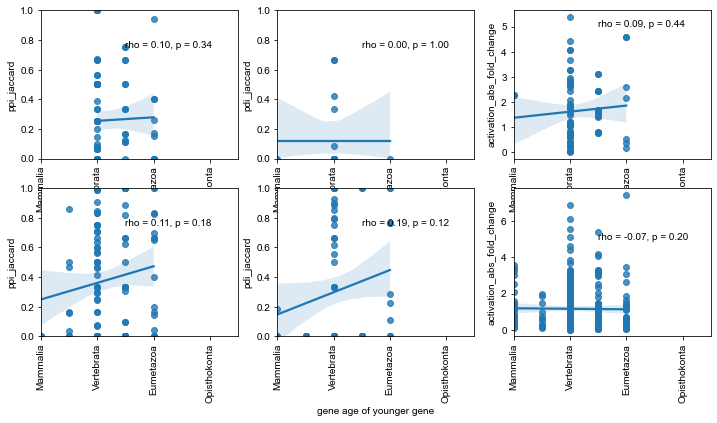

In [94]:
# TODO: map gene age to MYA
age_cats = df['gene_age_younger'].cat.categories.values
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['ppi_jaccard', 'pdi_jaccard', 'activation_abs_fold_change'], ax_row):
        data = df.loc[df['is_reference_comparison'] &
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='gene_age_younger_code',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        r, p = stats.spearmanr(data.loc[data['gene_age_younger_code'].notnull() & data[var].notnull(), 'gene_age_younger_code'].values,
                               data.loc[data['gene_age_younger_code'].notnull() & data[var].notnull(), var].values)
        ax.text(s='rho = {:.2f}, p = {:.2f}'.format(r, p),
                x=3, y=5 if var == 'activation_abs_fold_change' else 0.75)
        ax.set_xlim(0, len(age_cats) - 1)
        ax.set_xticklabels(age_cats)
axs[1, 1].set_xlabel('gene age of younger gene')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-gene-age_assaydiffs.pdf',
            bbox_inches='tight')

In [27]:
# TODO: move
df['gene_length_min'] = df[['gene_length_a', 'gene_length_b']].min(axis=1)
df['gene_length_max'] = df[['gene_length_a', 'gene_length_b']].max(axis=1)

In [86]:
df['gene_length_min_log10'] = df['gene_length_min'].apply(np.log10)
df['gene_length_max_log10'] = df['gene_length_max'].apply(np.log10)

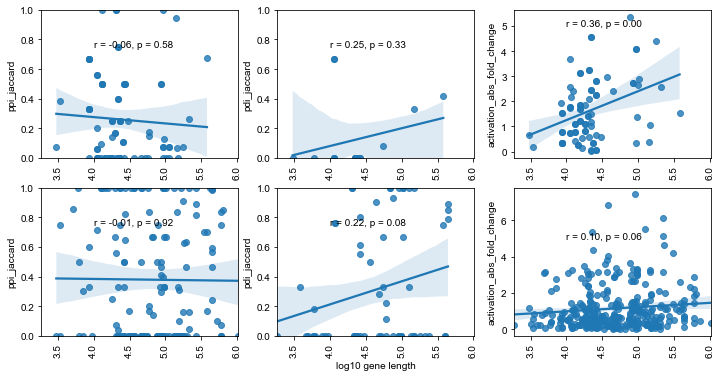

In [96]:
# TODO: log transform
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['ppi_jaccard', 'pdi_jaccard', 'activation_abs_fold_change'], ax_row):
        data = df.loc[df['is_reference_comparison'] &
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='gene_length_min_log10',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        ax.set_xlim(df['gene_length_min_log10'].min(), df['gene_length_min_log10'].max())
        r, p = stats.pearsonr(data.loc[data['gene_length_min_log10'].notnull() & data[var].notnull(), 'gene_length_min_log10'].values,
                              data.loc[data['gene_length_min_log10'].notnull() & data[var].notnull(), var].values)
        ax.text(s='r = {:.2f}, p = {:.2f}'.format(r, p),
                x=4, y=5 if var == 'activation_abs_fold_change' else 0.75)
#axs[0].set_ylabel('Activation fold change')
axs[1, 1].set_xlabel('log10 gene length')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-gene-length_assaydiffs.pdf',
            bbox_inches='tight')

In [ ]:
# expression level

<AxesSubplot: xlabel='pdi_n_min', ylabel='pdi_jaccard'>

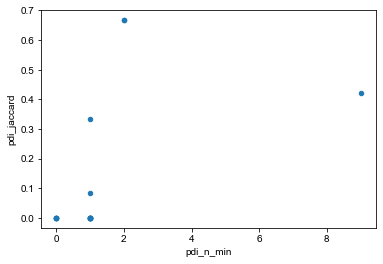

In [102]:
df.loc[df['pdi_n_min'].notnull() & 
       df['is_reference_comparison'] &
       (df['category'] == 'paralogs')
       , ['pdi_n_min', 'pdi_jaccard']].plot.scatter(x='pdi_n_min', y='pdi_jaccard')

In [109]:
genes = pd.DataFrame(data=[(name, len(tf.orfs), fam_size[name], gene_length[name], age[name] if name in age else np.nan) for name, tf in tfs.items()],
                     columns=['name', 'n_isoforms', 'family_size', 'gene_length', 'age'])
genes.head()

,name,n_isoforms,family_size,gene_length,age
0,ZBTB18,2,747.0,8538,Eumetazoa
1,PRRX1,3,196.0,76694,Eumetazoa
2,POU2F1,4,16.0,206470,Eumetazoa
3,ATF3,4,54.0,55444,Eumetazoa
4,GRHL3,6,6.0,45161,Opisthokonta


<AxesSubplot: xlabel='family_size', ylabel='n_isoforms'>

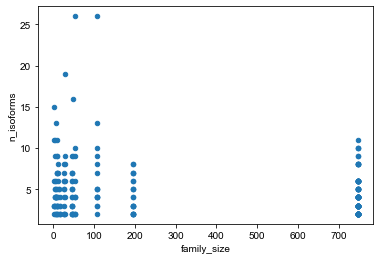

In [110]:
x = 'family_size'
y = 'n_isoforms'
fig, ax = plt.subplots(1, 1)
genes.plot.scatter(x=x, y=y)
